In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Grid visualization (2=robot, 1=neighbor, 0=other):
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0]
 [0 0 0 1 2 1 0 0]
 [0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


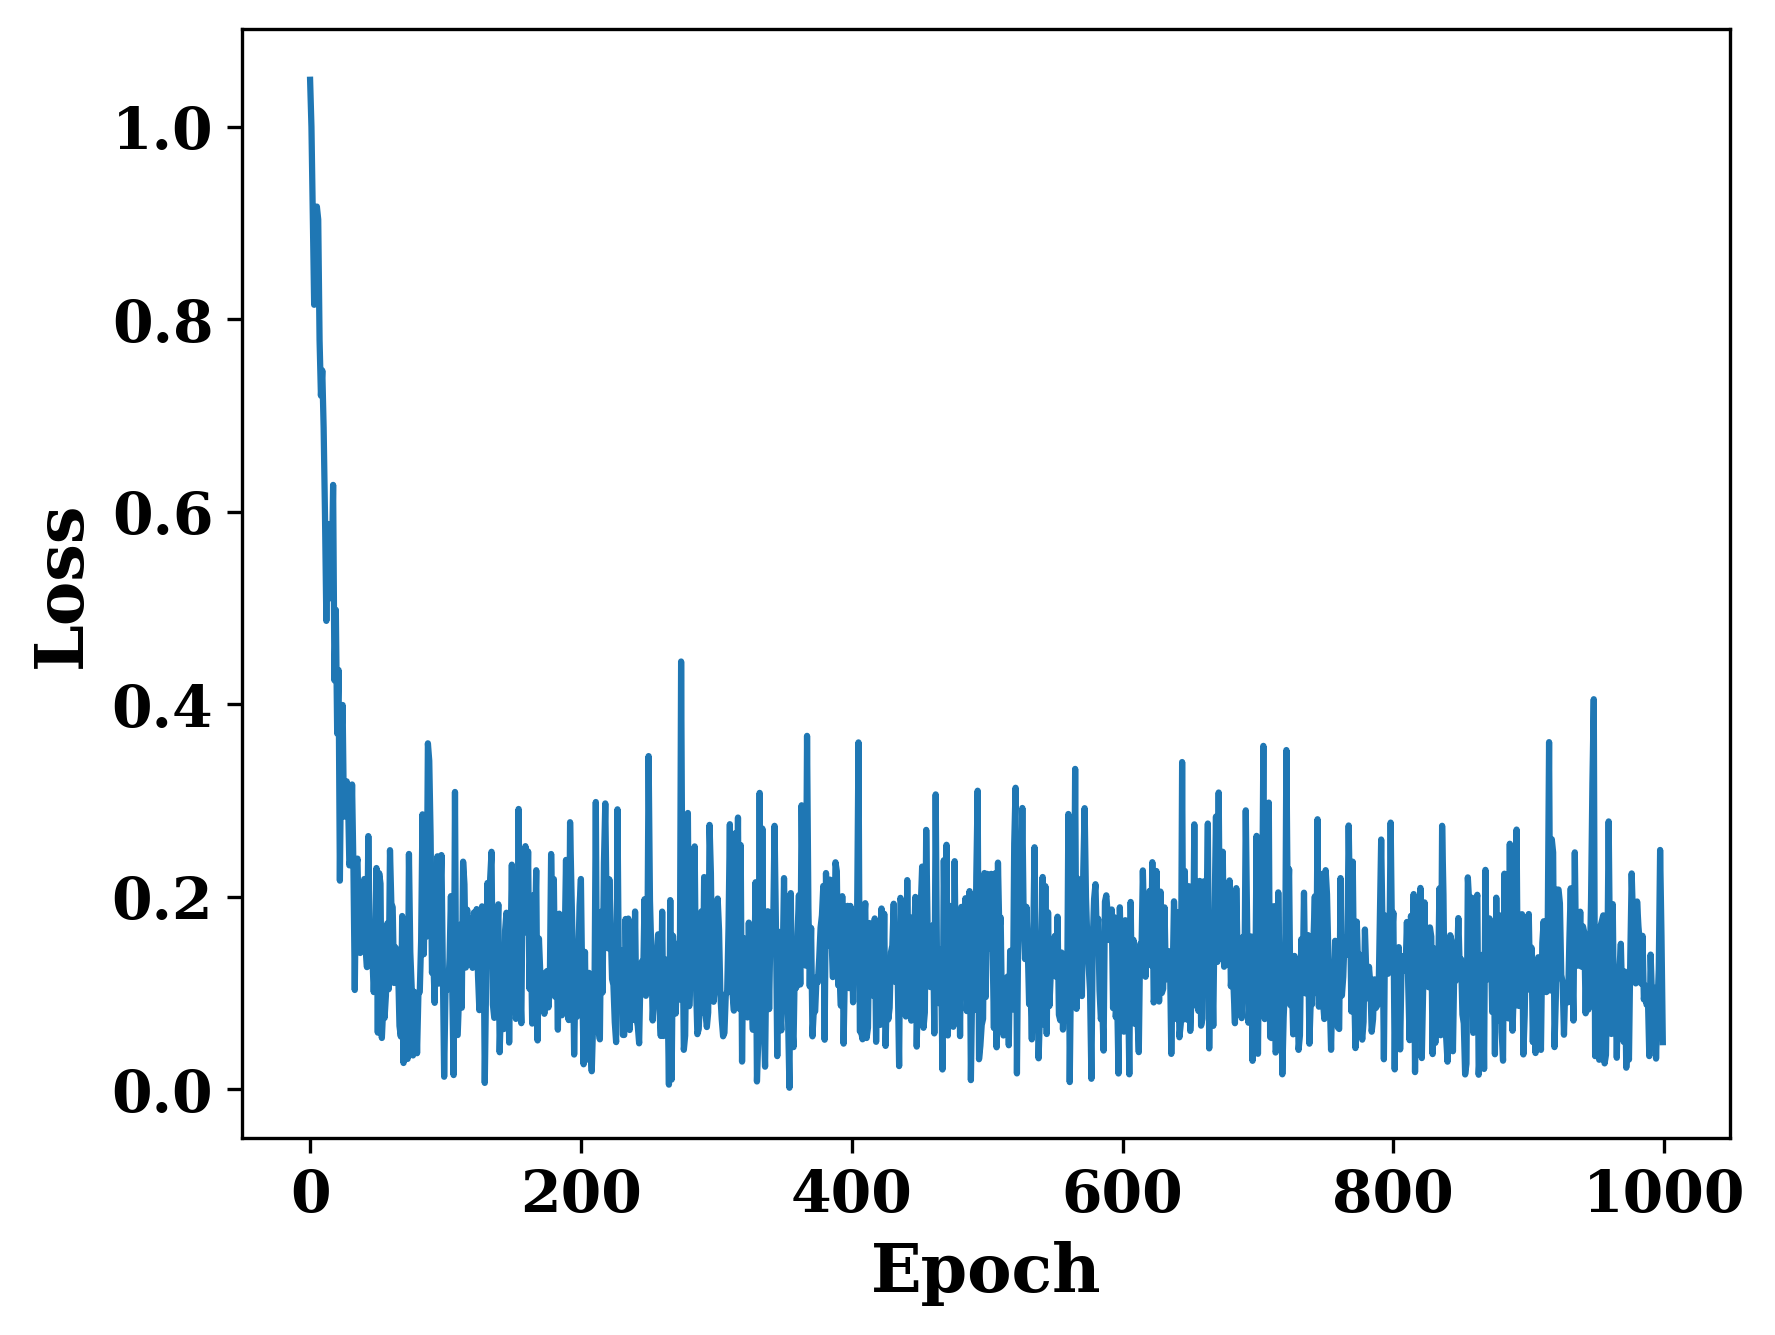

In [149]:
# BYOL for learning robot idx embeddings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class IntegerEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(IntegerEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, embedding_dim)
        self.linear2 = nn.Linear(embedding_dim, embedding_dim) 

    def forward(self, x):
        x = self.embedding(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return x

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()
def get_hexagonal_neighbors(index, grid_size=8):
    """
    Get indices of neighboring robots in a hexagonal grid.
    For even rows: neighbors are at top-left, top-right, left, right, bottom-left, bottom-right
    For odd rows: neighbors are at top-left, top-right, left, right, bottom-left, bottom-right
    """
    row, col = index // grid_size, index % grid_size
    neighbors = []
    
    # Check if we're on an even or odd row
    is_even_row = (row % 2 == 0)
    
    # Neighbor offsets for even and odd rows
    # Format: (row_offset, col_offset)
    if is_even_row:
        directions = [
            (-1, -1),  # top-left
            (-1, 0),   # top-right
            (0, -1),   # left
            (0, 1),    # right
            (1, -1),   # bottom-left
            (1, 0),    # bottom-right
        ]
    else:
        directions = [
            (-1, 0),   # top-left
            (-1, 1),   # top-right
            (0, -1),   # left
            (0, 1),    # right
            (1, 0),    # bottom-left
            (1, 1),    # bottom-right
        ]
    
    # Check each potential neighbor
    for row_offset, col_offset in directions:
        new_row = row + row_offset
        new_col = col + col_offset
        
        # Check if the neighbor is within grid bounds
        if (0 <= new_row < grid_size and 
            0 <= new_col < grid_size):
            neighbor_index = new_row * grid_size + new_col
            neighbors.append(neighbor_index)
    
    return np.array(neighbors)
def visualize_neighbors(index, grid_size=8):
    """
    Helper function to visualize the neighbors of a given robot
    """
    grid = np.zeros((grid_size, grid_size), dtype=int)
    row, col = index // grid_size, index % grid_size
    
    # Mark center robot
    grid[row, col] = 2
    
    # Mark neighbors
    neighbors = get_hexagonal_neighbors(index, grid_size)
    for n in neighbors:
        n_row, n_col = n // grid_size, n % grid_size
        grid[n_row, n_col] = 1
    
    return grid

# Test the function
# Example for a robot in the middle of the grid
test_index = 28  # Example index
grid = visualize_neighbors(test_index)

# Print the grid (2 is the robot, 1s are neighbors, 0s are other positions)
print("Grid visualization (2=robot, 1=neighbor, 0=other):")
print(grid)
# def get_neighbors(index, grid_size=8):
#     # Convert linear index to row and col
#     row, col = index // grid_size, index % grid_size
#     if row % 2 == 0:
#         neighbor_coords = [
#             (row-1, col),    # up
#             (row+1, col),    # down
#             (row, col-1),    # left
#             (row, col+1),    # right
#             (row-1, col-1),  # up-left
#             (row+1, col-1)   # down-left
#         ]
#     else:
#         neighbor_coords = [
#             (row-1, col),    # up
#             (row+1, col),    # down
#             (row, col-1),    # left
#             (row, col+1),    # right
#             (row-1, col+1),  # up-right
#             (row+1, col+1)   # down-right
#         ]

#     # Filter out neighbors that are outside the grid
#     valid_neighbors = []
#     for r, c in neighbor_coords:
#         if 0 <= r < grid_size and 0 <= c < grid_size:
#             valid_neighbors.append(r * grid_size + c)
    
#     return np.array(valid_neighbors)

def select_random_neighbors(batch_indices, neighbors):
    batch_size = len(batch_indices)
    random_neighbors = np.zeros(batch_size, dtype=int)
    for i in range(batch_size):
        neighbor_list = neighbors[batch_indices[i]]
        random_neighbors[i] = np.random.choice(neighbor_list)
    return random_neighbors

indices = np.arange(64)
neighbors = np.array([get_neighbors(i) for i in indices], dtype=object)
# print(neighbors)
# Model parameters
num_embeddings = 64  # For integers 0-63
embedding_dim = 256  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = IntegerEmbeddingModel(num_embeddings, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
triplet_loss = nn.TripletMarginLoss(margin=1, p=2, eps=1e-6)
cos = nn.CosineSimilarity(dim=1)

# Training loop
num_epochs = 1000
grid_size = 8
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    idxs = np.random.randint(0, num_embeddings, (batch_size,))

    indices = torch.tensor(idxs).to(device)
    embedding1 = model(indices)
    random_neighbors = torch.tensor(select_random_neighbors(idxs, neighbors)).to(device)
    embedding2 = model(random_neighbors)

    indices_2 = (indices + torch.randint(0, num_embeddings, (batch_size,)).to(device)) % num_embeddings  # Ensure it wraps around at the max integer
    embedding3 = model(indices_2.to(device))

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding2, embedding3)
    # print(1 + cos(embedding1, embedding2) - cos(embedding1, embedding3))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [150]:
# load toech model
# model.load_state_dict(torch.load('idx_embedding_128.pth', weights_only=True))

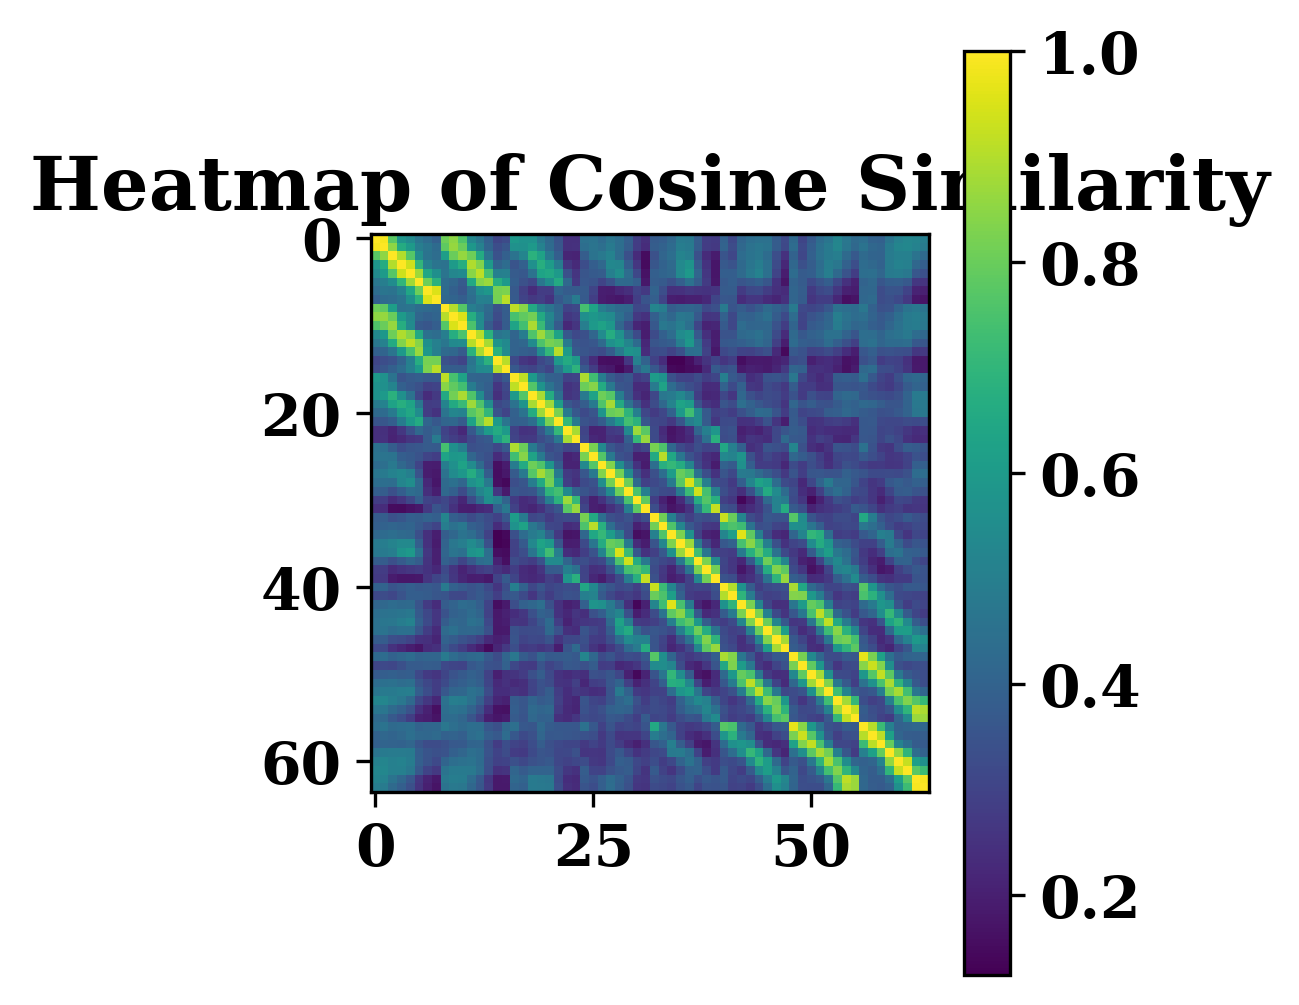

In [151]:
n_values = torch.arange(64).to(device)
a = model(n_values)
b = model(n_values)
cos_sim = torch.nn.CosineSimilarity(dim=0)

cos_sim_matrix = torch.zeros(64, 64)

for i in range(64):
    for j in range(64):
        cos_sim_matrix[i, j] = cos_sim(a[i], b[j])


# Plotting the heatmap
plt.figure(figsize=(3, 4))
plt.title("Heatmap of Cosine Similarity")
plt.imshow(cos_sim_matrix.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

/tmp/ipykernel_2499647/4203625862.py:52: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  hexagon = RegularPolygon(


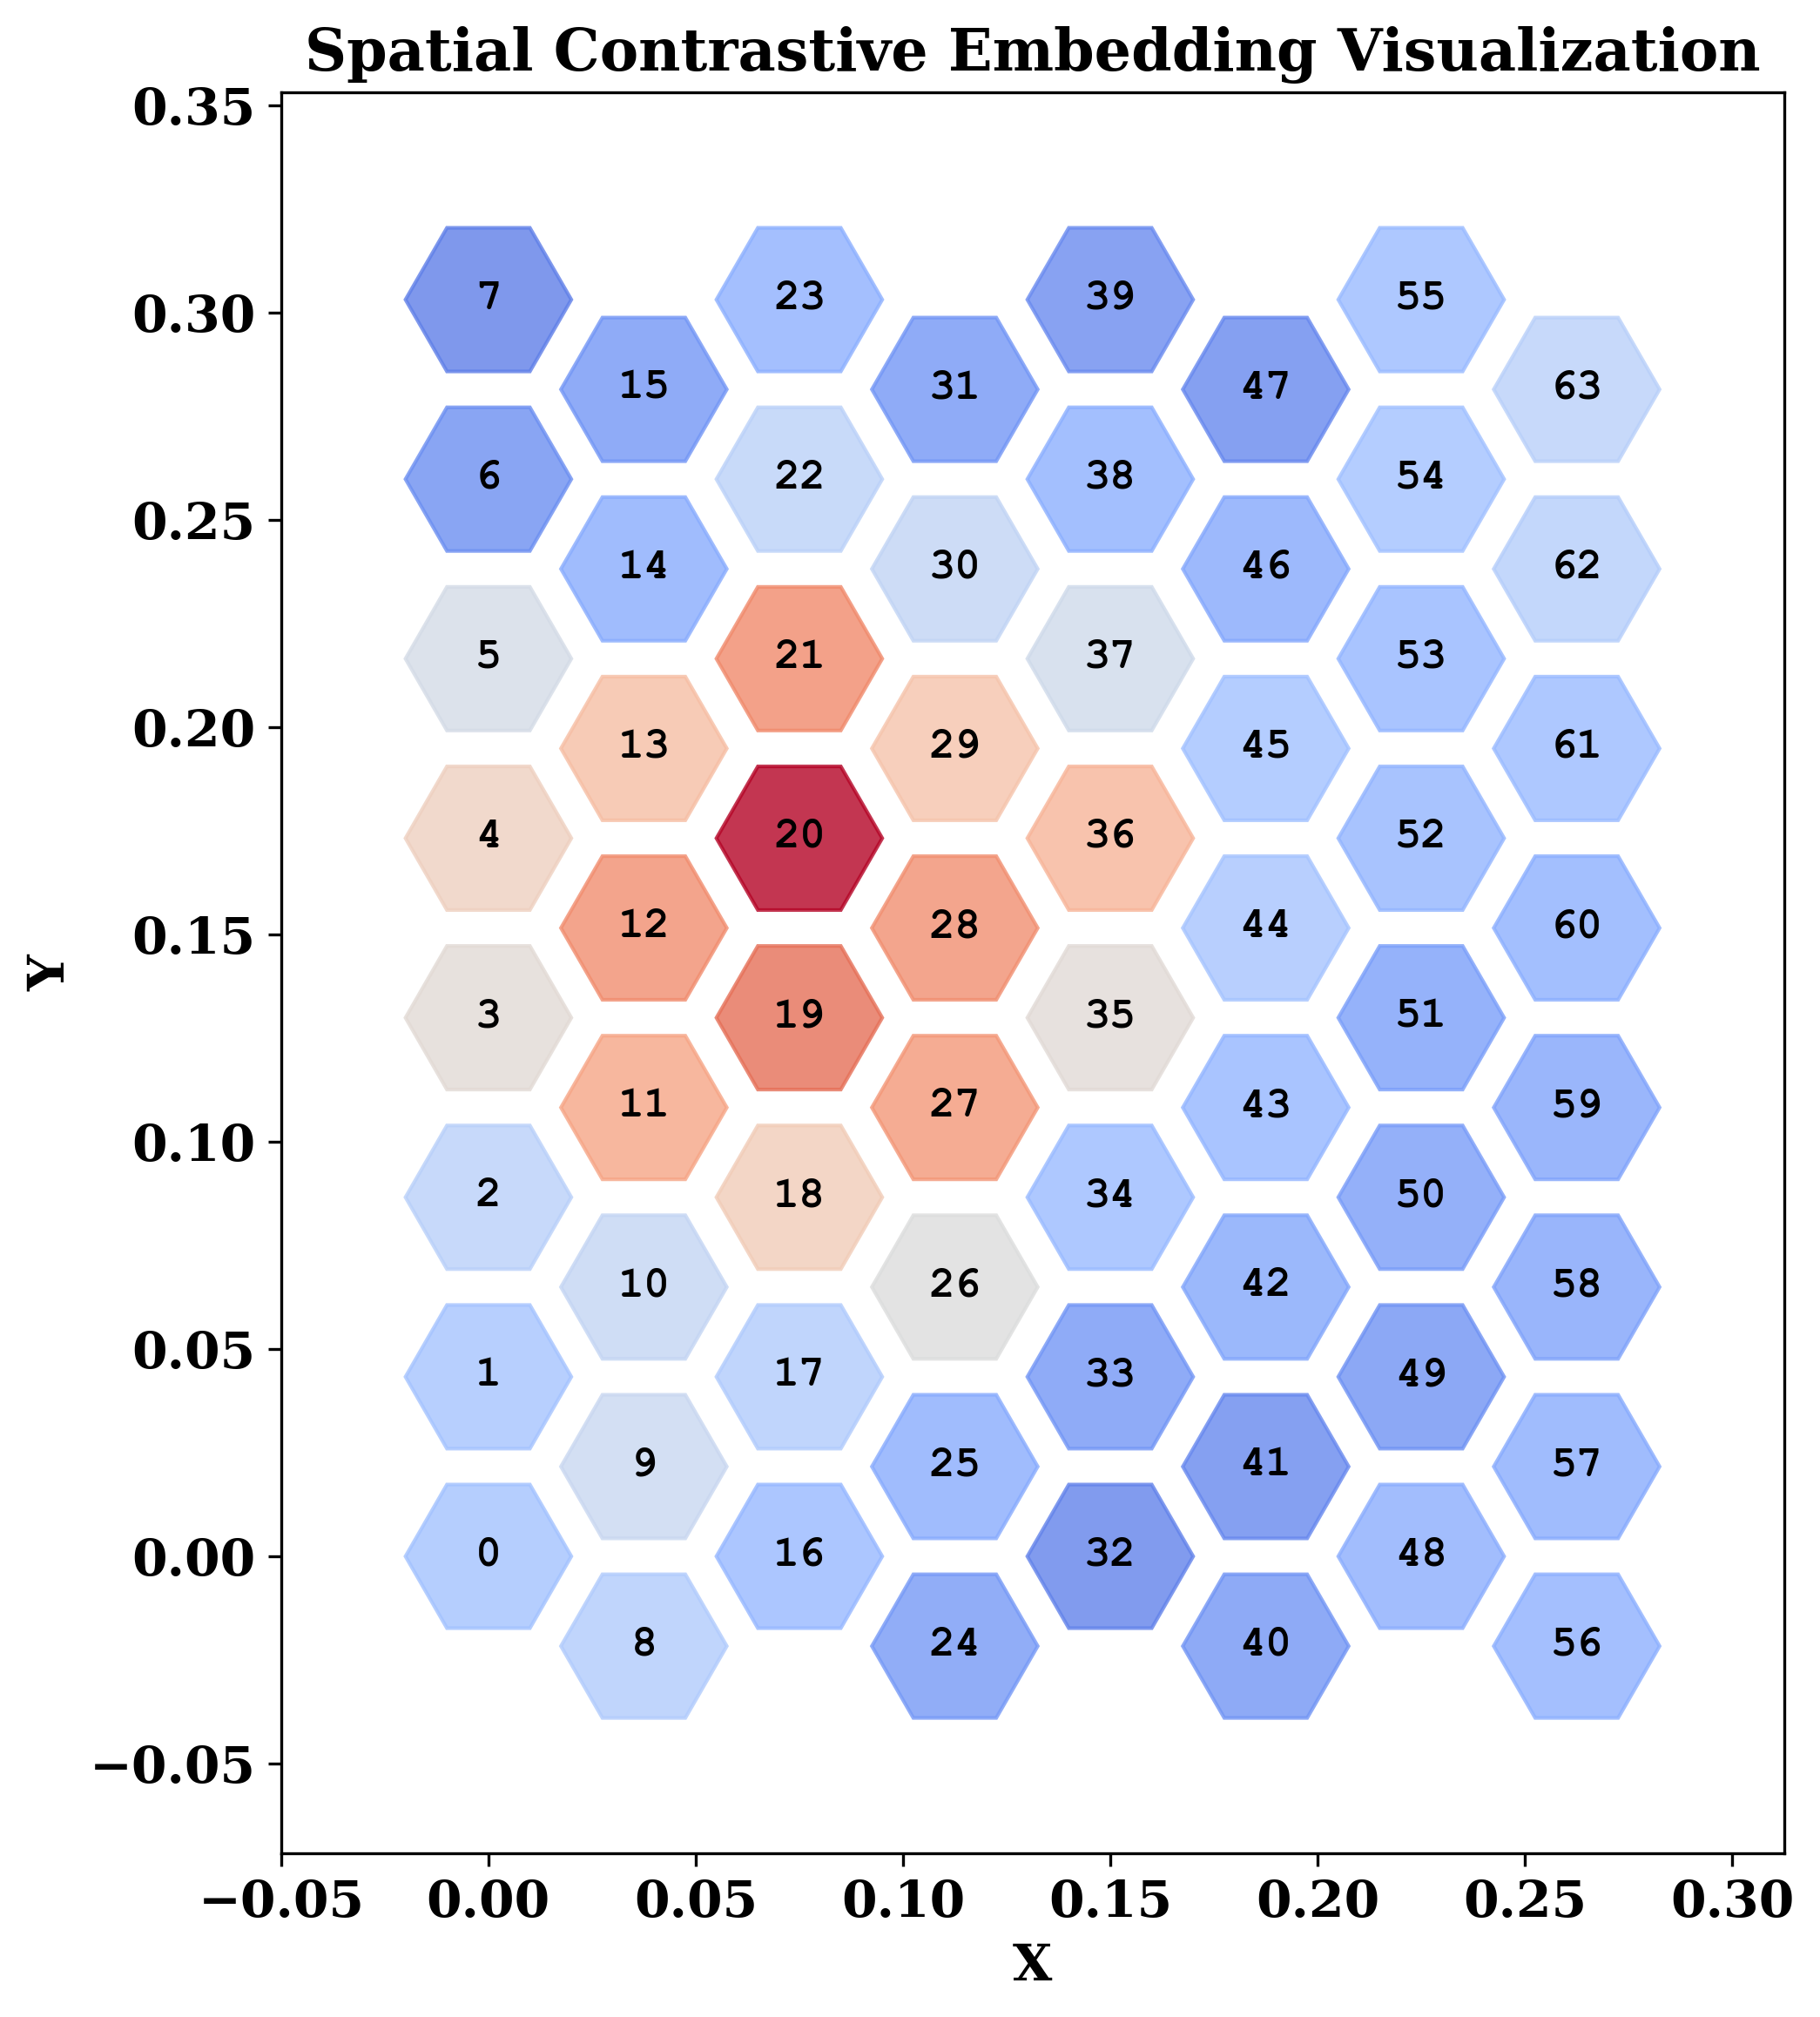

In [152]:
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import RegularPolygon
# mpl.font_manager._rebuild()


rb_pos_world = np.zeros((8,8,2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*0.0375, j*0.043301 - 0.02165))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
        else:
            finger_pos = np.array((i*0.0375, j*0.043301))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301))

with torch.no_grad():
    all_indices = torch.arange(num_embeddings, device=device)
    embedding_all = model(all_indices).cpu().numpy()

sim_matrix = np.corrcoef(embedding_all)

reference_robots = [20]  # Reference robot(s)
colormaps = ["coolwarm"]

# Extract robot positions
grid_size = 8
x_coords = rb_pos_world[:, :, 0].flatten()
y_coords = rb_pos_world[:, :, 1].flatten()

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Spatial Contrastive Embedding Visualization", fontsize=16)

# Adjust bounds for the hexagonal grid
x_min, x_max = x_coords.min() - 0.05, x_coords.max() + 0.05
y_min, y_max = y_coords.min() - 0.05, y_coords.max() + 0.05
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Plot hexagons for the reference robot
ref_robot = reference_robots[0]
similarities = sim_matrix[ref_robot]
sim_map = similarities.reshape(grid_size, grid_size)

for i in range(grid_size):
    for j in range(grid_size):
        hexagon = RegularPolygon(
            (rb_pos_world[i, j, 0], rb_pos_world[i, j, 1]),
            numVertices=6,
            radius=0.02,
            orientation=np.radians(30),
            color=mpl.colormaps.get_cmap(colormaps[0])(sim_map[i, j]),
            alpha=0.8,
            edgecolor='black'
        )
        ax.add_patch(hexagon)
        ax.text(rb_pos_world[i, j, 0], rb_pos_world[i, j, 1],
                str(i * grid_size + j),
                ha='center', va='center', fontsize=12, color='black', fontname="Courier New", weight='bold')

# Customize appearance
ax.set_xlabel("X", fontsize=14)
ax.set_ylabel("Y", fontsize=14)
ax.set_aspect('equal')
ax.grid(False)

plt.tight_layout()
plt.savefig("hexagonal_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

In [38]:
import matplotlib.font_manager
print(sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist]))

['Abyssinica SIL', 'Andale Mono', 'Andale Mono', 'Ani', 'AnjaliOldLipi', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial Black', 'Arial Black', 'C059', 'C059', 'C059', 'C059', 'Chandas', 'Chilanka', 'Comic Sans MS', 'Comic Sans MS', 'Comic Sans MS', 'Comic Sans MS', 'Courier New', 'Courier New', 'Courier New', 'Courier New', 'Courier New', 'Courier New', 'Courier New', 'Courier New', 'D050000L', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'Dhurjati', 'Droid Sans Fallback', 'Dyuthi', 'FreeMono', 'FreeMono', 'FreeMono', 'FreeMono', 'FreeSans', 'FreeSans', 'FreeSans', 'FreeSans', 'FreeSerif', 'FreeSerif', 'FreeSerif', 'FreeSerif', 'Gargi', 'Garuda', 'Garu

In [39]:
a.shape, embeddings.shape

NameError: name 'embeddings' is not defined

In [40]:
def generate_sinusoidal_embeddings(num_agents, dimensions):
    position = np.arange(num_agents)[:, np.newaxis]
    div_term = np.exp(np.arange(0, dimensions, 2) * -(np.log(10000.0) / dimensions))
    embeddings = np.zeros((num_agents, dimensions))
    embeddings[:, 0::2] = np.sin(position * div_term)
    embeddings[:, 1::2] = np.cos(position * div_term)
    return embeddings

from sklearn.metrics.pairwise import cosine_similarity
# Generate embeddings
embed1 = generate_sinusoidal_embeddings(64, 128)
embed2 = a.detach().cpu().numpy()
embed2 = embed2 / np.linalg.norm(embed2, axis=1, keepdims=True)
embed1 = torch.tensor(embed1)
embed2 = torch.tensor(embed2)
cos_sim_matrix1 = torch.zeros(64, 64)
cos_sim_matrix2 = torch.zeros(64, 64)
for i in range(64):
    for j in range(64):
        cos_sim_matrix1[i, j] = cos_sim(embed1[i], embed1[j])
        cos_sim_matrix2[i, j] = cos_sim(embed2[i], embed2[j])

# # Plotting the heatmap
# plt.figure(figsize=(12, 8))
# plt.imshow(embeddings, aspect='auto', cmap='viridis')
# plt.colorbar(label='Embedding Value')
# plt.title('Sinusoidal Position Embeddings Heatmap')
# plt.xlabel('Embedding Dimensions')
# plt.ylabel('Agent Index')
# plt.show()
# plt.figure(figsize=(12, 8))
# plt.imshow(embed2, aspect='auto', cmap='viridis')
# plt.colorbar(label='Embedding Value')
# plt.title('Sinusoidal Position Embeddings Heatmap')
# plt.xlabel('Embedding Dimensions')
# plt.ylabel('Agent Index')
# plt.show()

import seaborn as sns

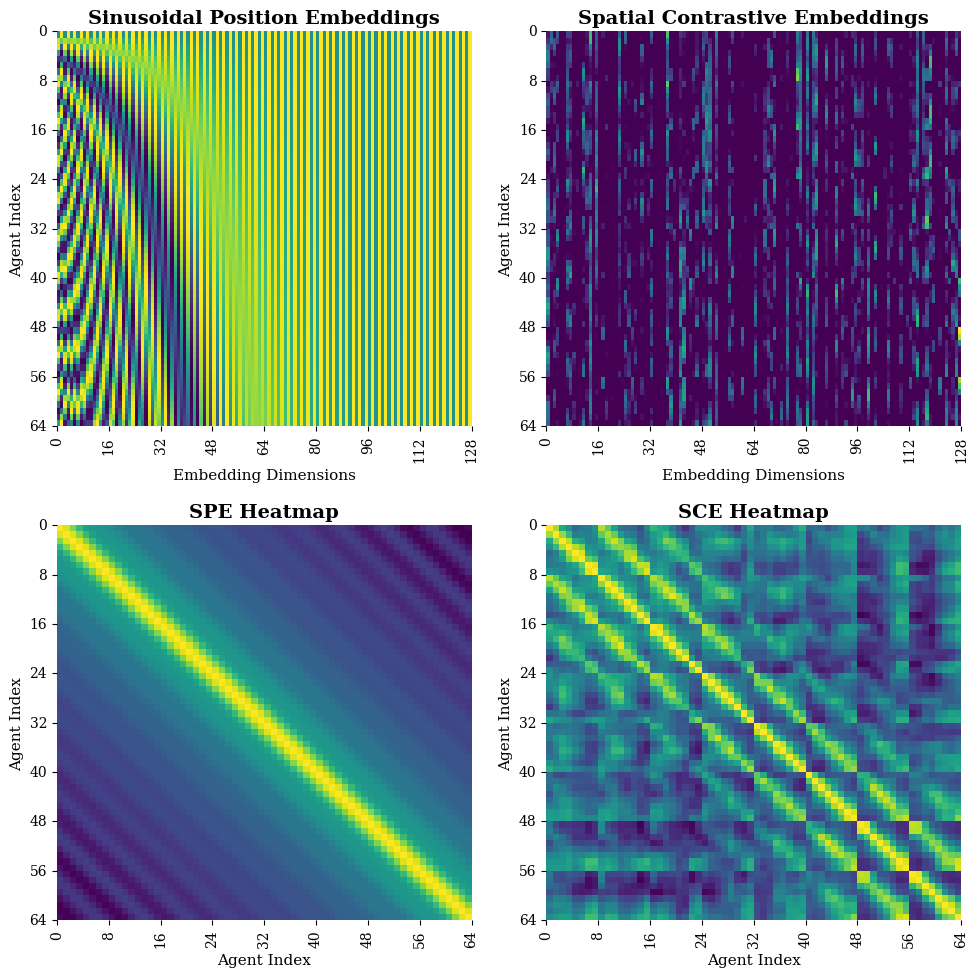

In [41]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
font = {'size': 14}
plt.rc('font', **font)
plt.rc('axes', titlesize=font['size'])
plt.rc('legend', fontsize=10)
plt.rc('figure', dpi=300)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

sns.heatmap(embed1, ax=axes[0, 0], cmap="viridis", cbar=False)
axes[0, 0].set_title('Sinusoidal Position Embeddings')
axes[0, 0].set_xlabel('Embedding Dimensions')
axes[0, 0].set_ylabel('Agent Index')
axes[0, 0].set_yticks(np.arange(0, 65, 8))
axes[0, 0].set_yticklabels(np.arange(0, 65, 8))
axes[0, 0].set_xticks(np.arange(0, 129, 16))
axes[0, 0].set_xticklabels(np.arange(0, 129, 16))

sns.heatmap(embed2, ax=axes[0, 1], cmap="viridis", cbar=False)
axes[0, 1].set_title('Spatial Contrastive Embeddings')
axes[0, 1].set_xlabel('Embedding Dimensions')
axes[0, 1].set_ylabel('Agent Index')
axes[0, 1].set_yticks(np.arange(0, 65, 8))
axes[0, 1].set_yticklabels(np.arange(0, 65, 8))
axes[0, 1].set_xticks(np.arange(0, 129, 16))
axes[0, 1].set_xticklabels(np.arange(0, 129, 16))

sns.heatmap(cos_sim_matrix1, ax=axes[1, 0], cmap="viridis", cbar=False)
axes[1, 0].set_title('SPE Heatmap')
axes[1, 0].set_xlabel('Agent Index')
axes[1, 0].set_ylabel('Agent Index')
axes[1, 0].set_yticks(np.arange(0, 65, 8))
axes[1, 0].set_yticklabels(np.arange(0, 65, 8))
axes[1, 0].set_xticks(np.arange(0, 65, 8))
axes[1, 0].set_xticklabels(np.arange(0, 65, 8))

sns.heatmap(cos_sim_matrix2, ax=axes[1, 1], cmap="viridis", cbar=False)
axes[1, 1].set_title('SCE Heatmap')
axes[1, 1].set_xlabel('Agent Index')
axes[1, 1].set_ylabel('Agent Index')
axes[1, 1].set_yticks(np.arange(0, 65, 8))
axes[1, 1].set_yticklabels(np.arange(0, 65, 8))
axes[1, 1].set_xticks(np.arange(0, 65, 8))
axes[1, 1].set_xticklabels(np.arange(0, 65, 8))

plt.tight_layout()
plt.show()

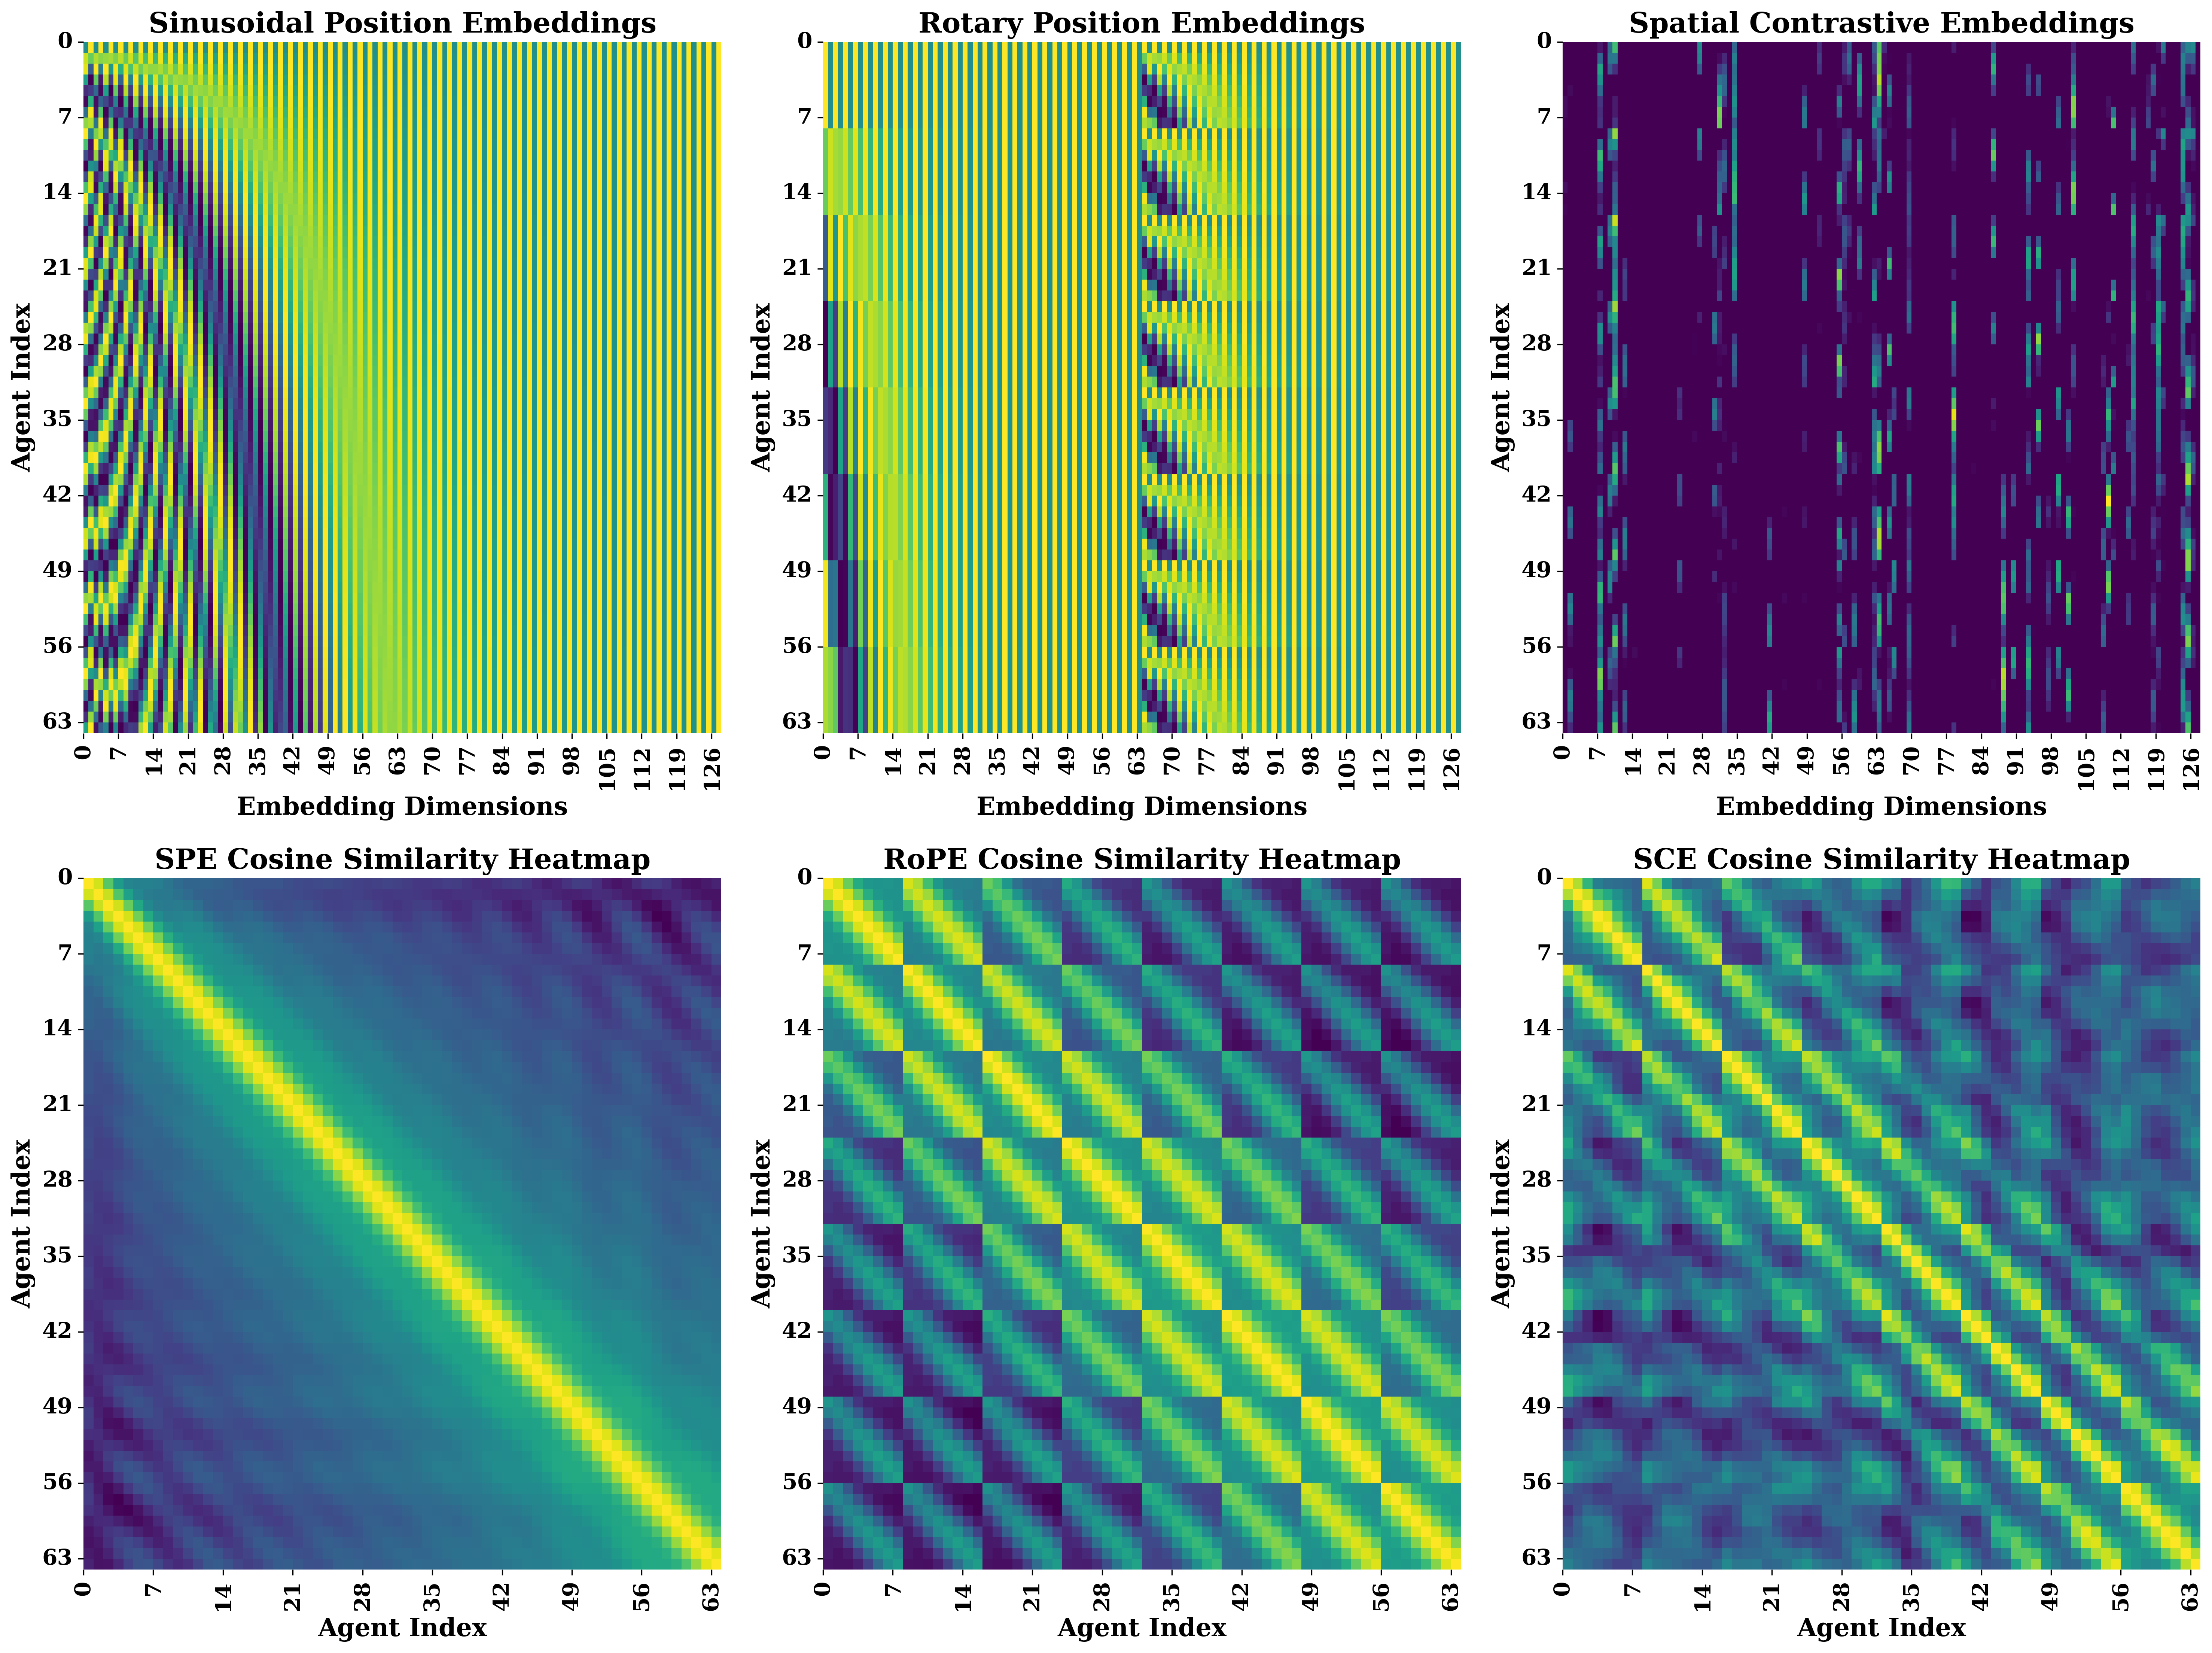

In [130]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Function to generate sinusoidal embeddings
def generate_sinusoidal_embeddings(num_agents, dimensions):
    position = np.arange(num_agents)[:, np.newaxis]
    div_term = np.exp(np.arange(0, dimensions, 2) * -(np.log(10000.0) / dimensions))
    embeddings = np.zeros((num_agents, dimensions))
    embeddings[:, 0::2] = np.sin(position * div_term)
    embeddings[:, 1::2] = np.cos(position * div_term)
    return embeddings

def generate_rotary_embeddings_2d(rows, cols, dimensions):
    """
    Generate RoPE embeddings for a 2D grid of agents
    """
    if dimensions % 4 != 0:  # Need to be divisible by 4 for 2D
        raise ValueError("Dimensions must be divisible by 4 for 2D RoPE")
        
    num_agents = rows * cols
    quarter_dim = dimensions // 4
    
    # Generate frequency bands
    freq = 1.0 / (10000 ** (np.arange(0, quarter_dim) / quarter_dim))
    
    # Create position-dependent phase for both x and y
    pos_x = (np.arange(rows)[:, None] * np.ones((1, cols))).flatten()[:, None]
    pos_y = (np.ones((rows, 1)) * np.arange(cols)[None, :]).flatten()[:, None]
    
    phase_x = pos_x * freq[None, :]  # [num_agents, quarter_dim]
    phase_y = pos_y * freq[None, :]  # [num_agents, quarter_dim]
    
    # Generate embeddings
    embeddings = np.zeros((num_agents, dimensions))
    
    # First half for x-position
    embeddings[:, 0:dimensions//2:2] = np.cos(phase_x)
    embeddings[:, 1:dimensions//2:2] = np.sin(phase_x)
    
    # Second half for y-position
    embeddings[:, dimensions//2::2] = np.cos(phase_y)
    embeddings[:, dimensions//2+1::2] = np.sin(phase_y)
    
    return embeddings

# Generate embeddings
num_agents = 64
dimensions = 128
sinusoidal_embeddings = generate_sinusoidal_embeddings(num_agents, dimensions)
rotary_embeddings = generate_rotary_embeddings_2d(8, 8, dimensions)
contrastive_embeddings = embedding_all

# Normalize embeddings
contrastive_embeddings /= np.linalg.norm(contrastive_embeddings, axis=1, keepdims=True)
sinusoidal_embeddings = torch.tensor(sinusoidal_embeddings)
rotary_embeddings = torch.tensor(rotary_embeddings)
contrastive_embeddings = torch.tensor(contrastive_embeddings)

# Compute cosine similarity matrices
cos_sim_matrix_spe = np.corrcoef(sinusoidal_embeddings.numpy())
cos_sim_matrix_rope = np.corrcoef(rotary_embeddings.numpy())
cos_sim_matrix_sce = np.corrcoef(contrastive_embeddings.numpy())

# Plot embeddings and similarity heatmaps
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 16,               # Base font size
    'font.weight': 'bold',         # Makes the base font bold
    'axes.titlesize': 18,          # Axes title size
    'axes.titleweight': 'bold',    # Makes the axes titles bold
    'axes.labelsize': 16,          # Axes label size
    'axes.labelweight': 'bold',    # Makes the axes labels bold
    'xtick.labelsize': 14,         # X-tick label size
    'ytick.labelsize': 14,         # Y-tick label size
    'figure.titlesize': 20,        # Figure title size
})

fig, axes = plt.subplots(2, 3, figsize=(20, 15))

# Helper function to set ticks every 7 steps
def set_ticks_every_7(ax, data, x_is_dims=True):
    """
    Set x- and y- ticks every 7 steps.
    x_is_dims=True  => x-axis corresponds to data.shape[1]
                       y-axis corresponds to data.shape[0].
    x_is_dims=False => x-axis corresponds to data.shape[0]
                       y-axis corresponds to data.shape[1].
    """
    # Adjust based on whether data's shape corresponds
    # to (num_rows, num_cols) = (agents, embedding_dims) or something else
    if x_is_dims:
        x_len = data.shape[1]
        y_len = data.shape[0]
    else:
        x_len = data.shape[0]
        y_len = data.shape[1]

    ax.set_xticks(np.arange(0, x_len, 7))
    ax.set_yticks(np.arange(0, y_len, 7))
    # (Optionally) set the labels if you'd like them to match the numeric range:
    ax.set_xticklabels(np.arange(0, x_len, 7))
    ax.set_yticklabels(np.arange(0, y_len, 7))

# ============== Sinusoidal Position Embeddings ==============
sns.heatmap(sinusoidal_embeddings, ax=axes[0, 0], cmap="viridis", cbar=False)
axes[0, 0].set_title('Sinusoidal Position Embeddings')
axes[0, 0].set_xlabel('Embedding Dimensions')
axes[0, 0].set_ylabel('Agent Index')
set_ticks_every_7(axes[0, 0], sinusoidal_embeddings, x_is_dims=True)

# ============== Rotary Position Embeddings ==============
sns.heatmap(rotary_embeddings, ax=axes[0, 1], cmap="viridis", cbar=False)
axes[0, 1].set_title('Rotary Position Embeddings')
axes[0, 1].set_xlabel('Embedding Dimensions')
axes[0, 1].set_ylabel('Agent Index')
set_ticks_every_7(axes[0, 1], rotary_embeddings, x_is_dims=True)

# ============== Spatial Contrastive Embeddings ==============
sns.heatmap(contrastive_embeddings, ax=axes[0, 2], cmap="viridis", cbar=False)
axes[0, 2].set_title('Spatial Contrastive Embeddings')
axes[0, 2].set_xlabel('Embedding Dimensions')
axes[0, 2].set_ylabel('Agent Index')
set_ticks_every_7(axes[0, 2], contrastive_embeddings, x_is_dims=True)

# ============== SPE Heatmap ==============
sns.heatmap(cos_sim_matrix_spe, ax=axes[1, 0], cmap="viridis", cbar=False)
axes[1, 0].set_title('SPE Cosine Similarity Heatmap')
axes[1, 0].set_xlabel('Agent Index')
axes[1, 0].set_ylabel('Agent Index')
set_ticks_every_7(axes[1, 0], cos_sim_matrix_spe, x_is_dims=False)

# ============== RoPE Heatmap ==============
sns.heatmap(cos_sim_matrix_rope, ax=axes[1, 1], cmap="viridis", cbar=False)
axes[1, 1].set_title('RoPE Cosine Similarity Heatmap')
axes[1, 1].set_xlabel('Agent Index')
axes[1, 1].set_ylabel('Agent Index')
set_ticks_every_7(axes[1, 1], cos_sim_matrix_rope, x_is_dims=False)

# ============== SCE Heatmap ==============
sns.heatmap(cos_sim_matrix_sce, ax=axes[1, 2], cmap="viridis", cbar=False)
axes[1, 2].set_title('SCE Cosine Similarity Heatmap')
axes[1, 2].set_xlabel('Agent Index')
axes[1, 2].set_ylabel('Agent Index')
set_ticks_every_7(axes[1, 2], cos_sim_matrix_sce, x_is_dims=False)

plt.tight_layout()

# Show interactively (remove if running in a script without a GUI)
plt.show()

# ============== Save at high resolution ==============
# You can save at 300 dpi or higher if needed for print/publication
fig.savefig("my_figure.png", dpi=300, bbox_inches='tight')


/tmp/ipykernel_2499647/3859459493.py:52: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  hexagon = RegularPolygon(
/tmp/ipykernel_2499647/3859459493.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


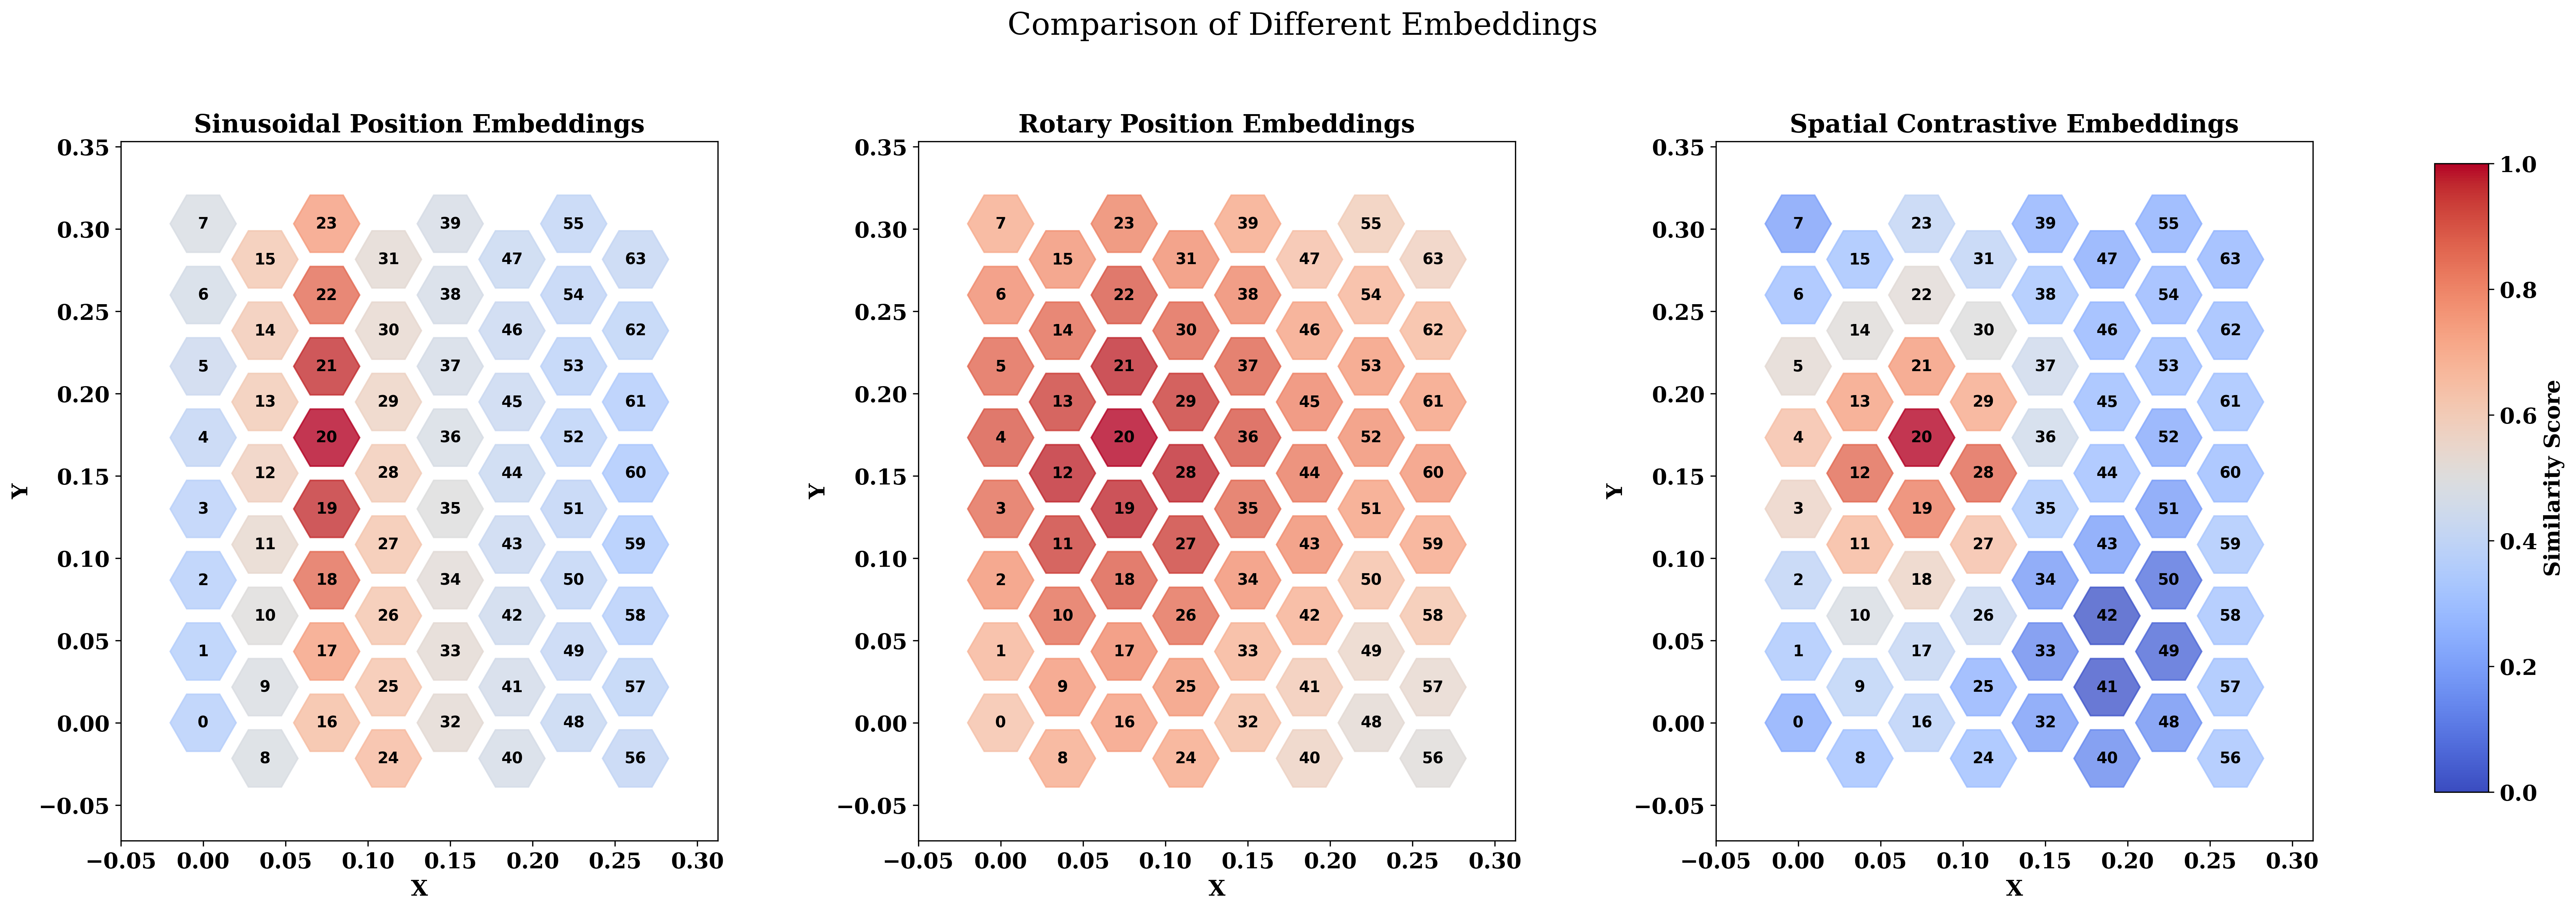

In [127]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

# Generate hexagonal grid positions
rb_pos_world = np.zeros((8, 8, 2))
for i in range(8):
    for j in range(8):
        if i % 2 != 0:
            rb_pos_world[i, j] = [i * 0.0375, j * 0.043301 - 0.02165]
        else:
            rb_pos_world[i, j] = [i * 0.0375, j * 0.043301]

# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle("Comparison of Different Embeddings", fontsize=20, y=1.02)

embeddings = [
    (cos_sim_matrix_spe, "Sinusoidal Position Embeddings"),
    (cos_sim_matrix_rope, "Rotary Position Embeddings"),
    (cos_sim_matrix_sce, "Spatial Contrastive Embeddings")
]

for idx, (embed, title) in enumerate(embeddings):
    sim_matrix = embed
    reference_robots = [20]  # Reference robot(s)

    # Extract robot positions
    x_coords = rb_pos_world[:, :, 0].flatten()
    y_coords = rb_pos_world[:, :, 1].flatten()

    # Set up subplot
    ax = axes[idx]
    # ax.axis('off')
    # plt.gca().set_frame_on(True)
    ax.set_title(title, fontsize=16)

    # Adjust bounds for the hexagonal grid
    x_min, x_max = x_coords.min() - 0.05, x_coords.max() + 0.05
    y_min, y_max = y_coords.min() - 0.05, y_coords.max() + 0.05
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Plot hexagons
    ref_robot = reference_robots[0]
    similarities = sim_matrix[ref_robot]
    sim_map = similarities.reshape(8, 8)

    for i in range(8):
        for j in range(8):
            hexagon = RegularPolygon(
                (rb_pos_world[i, j, 0], rb_pos_world[i, j, 1]),
                numVertices=6,
                radius=0.02,
                orientation=np.radians(30),
                color=plt.cm.coolwarm(sim_map[i, j]),
                alpha=0.8,
                edgecolor='black'
            )
            ax.add_patch(hexagon)
            ax.text(rb_pos_world[i, j, 0], rb_pos_world[i, j, 1],
                    str(i * 8 + j),
                    ha='center', va='center', fontsize=10,
                    color='black', fontname="DejaVu Sans", weight='bold')

    # Customize appearance
    ax.set_xlabel("X", fontsize=14)
    ax.set_ylabel("Y", fontsize=14)
    ax.set_aspect('equal')
    ax.grid(False)

# Add a colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.coolwarm, norm=norm)
cb.set_label('Similarity Score', fontsize=14)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.show()
fig.savefig("similarity_w_bbox.png", dpi=300, bbox_inches='tight')


In [56]:
# torch.save(model.state_dict(), 'idx_embedding_128.pth')

In [157]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#################################
# Configuration / Setup
#################################
# You can group your runs by category for convenience.
# For each category, list the run names (or run IDs) you want to include.

# For all expts seeds are: 13, 69, 420, 555, 768
MATSAC_SA_runs = [
    "sbp_team/MARL_Dexterous_Manipulation/edypxdck",  # e.g., "user/MARL_Dexterous_Manipulation/abc123"
    "sbp_team/MARL_Dexterous_Manipulation/isvi3i1i",
    "sbp_team/MARL_Dexterous_Manipulation/si4j2ehm",
    "sbp_team/MARL_Dexterous_Manipulation/34wmnwcv",
    "sbp_team/MARL_Dexterous_Manipulation/xlhj4429",
]

MATSAC_CA_runs = [
    "sbp_team/MARL_Dexterous_Manipulation/014kayig",
    "sbp_team/MARL_Dexterous_Manipulation/gv914b1f",
    "sbp_team/MARL_Dexterous_Manipulation/y7uw7wo4",
    "sbp_team/MARL_Dexterous_Manipulation/l9k0908s",
    "sbp_team/MARL_Dexterous_Manipulation/wj0tc1gq",
]

MATSAC_AdaLN_runs = [
    "sbp_team/MARL_Dexterous_Manipulation/f0cre312",
    "sbp_team/MARL_Dexterous_Manipulation/zwhz6a8b",
    "sbp_team/MARL_Dexterous_Manipulation/llexawps",
    "matsac_mj_adaln_test_555",
    "matsac_mj_adaln_test_768",
]

MATSAC_SPE_RUNS = [
    "sbp_team/MARL_Dexterous_Manipulation/rpyqpv71",
    "sbp_team/MARL_Dexterous_Manipulation/h1inac0m",
    
]

MATSAC_RoPE_RUNS=[
    
]

MATSAC_Rope_runs = [
    "sbp_team/MARL_Dexterous_Manipulation/u5jdp70l",
    "matsac_mj_rope_test_69",
    "matsac_mj_rope_test_420",
]

MATSAC_RopeFinetune_runs = [
    "matsac_mj_finetune_rope",
]

# Customize which metrics (columns) you want to retrieve from each run’s history
# Example metrics might be: ["global_step", "train_reward_mean", "eval_success_rate"]
# Adjust to match your actual logging keys.
METRICS_TO_PULL = ["Reward", "Inference Reward", "std", 'mu', 'Q loss', 'Pi loss']

# Plot settings
sns.set_theme(context="paper", style="whitegrid", font_scale=1.3)
plt.rcParams.update({
    "figure.dpi": 150,
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
})

#################################
# Data Retrieval
#################################

def fetch_run_history(run_path, metrics):
    """
    Fetches history (pandas DataFrame) for a given W&B run path (e.g. "user/project/run_id"),
    including only the specified metrics.
    """
    api = wandb.Api()
    run = api.run(run_path)
    
    # We only keep the columns we care about
    history = run.history(keys=metrics)
    history["run_name"] = run.name or run.id  # Add a column for run name
    return history


def build_combined_df(runs_list, run_label, metrics):
    """
    Loops over runs in runs_list, fetches the history for each,
    and concatenates them into a single DataFrame with an extra label column.
    """
    dfs = []
    for r in runs_list:
        df_tmp = fetch_run_history(r, metrics)
        df_tmp["category"] = run_label  # e.g., "MATSAC_SA" or "MATSAC_CA"
        dfs.append(df_tmp)
    combined = pd.concat(dfs, ignore_index=True)
    return combined


# Build a master DataFrame with data from all run categories.
master_df = pd.DataFrame()

# Example: MATSAC SA
if MATSAC_SA_runs:
    df_sa = build_combined_df(MATSAC_SA_runs, "MATSAC_SA", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_sa], ignore_index=True)

# Example: MATSAC CA
if MATSAC_CA_runs:
    df_ca = build_combined_df(MATSAC_CA_runs, "MATSAC_CA", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_ca], ignore_index=True)

# Example: MATSAC AdaLN
if MATSAC_AdaLN_runs:
    df_adaln = build_combined_df(MATSAC_AdaLN_runs, "MATSAC_AdaLN", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_adaln], ignore_index=True)

# Example: MATSAC Rope
if MATSAC_Rope_runs:
    df_rope = build_combined_df(MATSAC_Rope_runs, "MATSAC_Rope", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_rope], ignore_index=True)

# Example: MATSAC Rope Finetune
if MATSAC_RopeFinetune_runs:
    df_rope_ft = build_combined_df(MATSAC_RopeFinetune_runs, "MATSAC_RopeFinetune", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_rope_ft], ignore_index=True)

#################################
# Example Visualizations
#################################

# 1) Compare 'train_reward_mean' across categories
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=master_df,
    x="global_step",
    y="train_reward_mean",
    hue="category",
    estimator="mean",  # or None if you want to plot all seeds
    ci="sd",           # can use "sd" or 95 for confidence intervals
    palette="deep"
)
plt.title("Training Reward Across Categories")
plt.xlabel("Global Step")
plt.ylabel("Average Training Reward")
plt.tight_layout()
plt.show()


# 2) Compare 'eval_success_rate' across categories
if "eval_success_rate" in master_df.columns:
    plt.figure(figsize=(6, 4))
    sns.lineplot(
        data=master_df,
        x="global_step",
        y="eval_success_rate",
        hue="category",
        estimator="mean",
        ci="sd",
        palette="deep"
    )
    plt.title("Evaluation Success Rate Across Categories")
    plt.xlabel("Global Step")
    plt.ylabel("Evaluation Success Rate")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


# 3) If you want to separate seeds within the same category, 
#    color by run_name and style by category, for example:
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=master_df,
    x="global_step",
    y="train_reward_mean",
    hue="run_name",     # Distinguish each run
    style="category",   # Distinguish categories by line style
    estimator="mean",
    ci="sd"
)
plt.title("Training Reward by Run and Category")
plt.xlabel("Global Step")
plt.ylabel("Average Training Reward")
plt.tight_layout()
plt.show()

#################################
# Tips
#################################
# - You can adjust palette, line styles, or any matplotlib/seaborn setting 
#   to achieve the desired "publication-ready" look.
# - If your x-axis is not `global_step` but something else (e.g., `timesteps`), 
#   just replace occurrences of "global_step" with your actual step key.
# - For large numbers of runs, you might want to group seeds or use an average 
#   with confidence intervals to keep the plot uncluttered.
# - Always verify that the keys in METRICS_TO_PULL match the exact names you 
#   used when logging in wandb (case-sensitive).
# - If you’re dealing with large data, consider fetching fewer steps (e.g., 
#   run.scan_history()) or downsampling the data for plotting.



KeyboardInterrupt: 